In [2]:
import numpy as np
import random

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.preprocessing import image
from PIL import Image
import os

# generowanie sztucznego zbioru uczącego - generowanie obrazków na podstawie źródła
root_folder = '.\\F1 Teams\\'
list_of_teams = os.listdir(root_folder)
class_to_name = {}
for i, team in enumerate(list_of_teams):
    class_to_name[i] = team


def create_dataset(image_name, directory, number_of_samples=250):
    folder_name = directory.split("\\")[-1]
    for i in range(number_of_samples):
        try:
            with Image.open(f".\\{directory}\\{image_name}") as img:
                angle = random.uniform(0, 360)
                rotated_img = img.rotate(angle, expand=True)
                augmented_path = f".\\{directory}\\{folder_name}_{i}.jpg"
                final_image = rotated_img.resize((250, 250))
                final_image.save(augmented_path)

        except Exception as e:
            print(f"Error processing {image_name}: {e}")


for root, dirs, files in os.walk(root_folder):
    for file in files:
        if file == "logo.jpg":
            create_dataset(file, f"{root}")


Found 2510 files belonging to 10 classes.


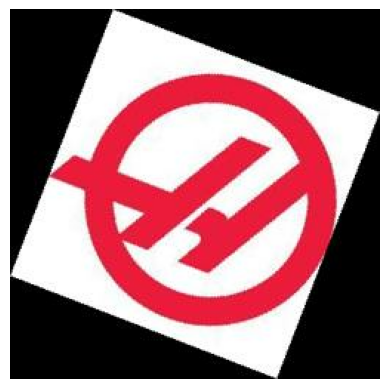

One-Hot Encoded Label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Class Index: 3
<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [19]:
number_of_classes = 10
image_size = (250, 250)
batch_size = 32

# podział danych na zbiory uczące i zbiory testowe
data = keras.utils.image_dataset_from_directory(
    "F1 teams",
    seed=1337,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)


import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
for images, labels in data.take(1):  # Take 1 batch from the dataset
    # Select the first image and label
    img = images[0].numpy().astype("uint8")  # Convert to uint8 for visualization
    label = labels[0].numpy()               # Get the corresponding label

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Print the label (one-hot encoded)
    print("One-Hot Encoded Label:", label)

    # Convert one-hot encoding to class index
    label_index = np.argmax(label)
    print("Class Index:", label_index)

    # Break the loop after displaying the first image
    break

# konwersja etykiet do danych kategorycznych
images = np.array(data)
print(data.take(5))
# label_encoder = LabelEncoder()
# y = to_categorical(label_encoder.fit_transform(labels))  
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
# definicja modelu
model = keras.Sequential([
    layers.Input(shape=(250, 250, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(number_of_classes, activation='softmax')
])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    27,558,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,653,962 (105.49 MB)

 Trainable params: 27,653,962 (105.49 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# uczenie modelu
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])
model.fit(train_data, batch_size=32, epochs=15)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 660ms/step - accuracy: 0.4051 - loss: 2.7538
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 643ms/step - accuracy: 0.9532 - loss: 0.1203
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 641ms/step - accuracy: 0.9967 - loss: 0.0148
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 639ms/step - accuracy: 0.9927 - loss: 0.0213
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 640ms/step - accuracy: 0.9998 - loss: 0.0021
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 642ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 653ms/step - accuracy: 0.9992 - loss: 0.0026
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 646ms/step - accuracy: 0.9968 - loss: 0.0102
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 642ms/step - accuracy: 0.9996 - loss: 0.0029
Epoch 10/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.9989 - loss: 0.0060
Epoch 11/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.9975 - loss: 0.0139
Epoch 12/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41

In [10]:
# zapisanie modelu do pliku 
# model.save("F1_team_logos.keras")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
Accuracy: 0.08366533864541832
Precision: 0.08366533864541832
Recall: 0.08366533864541832
F1 Score: 0.08366533864541832

Classification Report:
               precision    recall  f1-score   support

           0       0.02      0.02      0.02        42
           1       0.07      0.07      0.07        54
           2       0.02      0.02      0.02        50
           3       0.09      0.09      0.09        46
           4       0.09      0.09      0.09        56
           5       0.06      0.06      0.06        47
           6       0.07      0.07      0.07        54
           7       0.08      0.08      0.08        51
           8       0.15      0.15      0.15        52
           9       0.16      0.16      0.16        50

    accuracy                           0.08       502
   macro avg       0.08      0.08      0.08       502
weighted avg       0.08      0.08      0.08       502



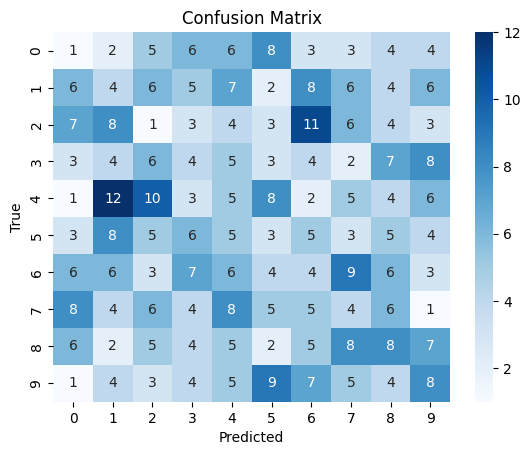

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Ferrari


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for _, y in validation_data], axis=0)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



# ręczne sprawdzenie modelu na danych spoza zbioru
image_path = ".\\F1 teams\\test.jpg" # oczekiwana klasa: Ferrari

# przekształcenie obrazka do postaci przyjmowanej przez model
img = image.load_img(image_path, target_size=(250, 250))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

prediction = model.predict(img_array)

predicted_class = np.argmax(prediction, axis=-1)[0]
print(class_to_name[predicted_class])